In [ ]:
%pip install -q -U gdown==5.2.0 supervision==0.24.0 ultralytics==8.3.12 lapx==0.5.11
import os
import subprocess
import warnings
from collections import defaultdict
from typing import Any
import cv2 as cv
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import supervision as sv
from IPython.display import Video
from numpy.typing import ArrayLike, NDArray
from scipy.signal import savgol_filter
from ultralytics import YOLO

In [18]:
TICKSIZE = 12
FONT_COLOR = "#4A4B52"
GRADIENT_COLOR = "#BAB8B8"
BACKGROUND_COLOR = "#FFFCFA"
# TEXT = r"\textrm{{{}}}"

MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 16,
    "axes.grid": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 16,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    # "text.usetex": True,
    "font.family": "Serif",
}
plt.rcParams.update(MATPLOTLIB_THEME)

SOURCE_VIDEO = "vehicles.mp4"


def imshow(img, figsize: tuple[int, int] = (11, 7)) -> None:
    plt.figure(figsize=figsize, tight_layout=True)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [19]:
Video(url = SOURCE_VIDEO, width=960, height=540)

In [20]:
class PointMarker:
    """Mark points on an image using Left Mouse Button click."""

    def __init__(self, window: str = "Image") -> None:
        self._window = window
        self._points: list[tuple[int, int]] = list()

    def __call__(self, image: NDArray, inplace: bool = False) -> list[tuple[int, int]]:
        return self.mark(image, inplace)

    @property
    def points(self) -> list[tuple[int, int]]:
        return self._points

    def mark(self, image: NDArray, inplace: bool = False) -> list[tuple[int, int]]:
        if not inplace:
            image = image.copy()
        cv.namedWindow(self._window, cv.WINDOW_NORMAL)
        cv.setMouseCallback(self._window, self._record_point, param=image)

        while True:
            cv.imshow(self._window, image)
            if cv.waitKey(1) == ord("q"):
                break

        cv.destroyAllWindows()
        return self._points

    def _record_point(self, event: int, x: int, y: int, flags: int, image: Any | None) -> None:
        if event == cv.EVENT_LBUTTONDOWN:
            self._points.append((x, y))
            if image is not None:
                self._draw_point(image, (x, y))

    def _draw_point(self, image: NDArray, point: tuple[int, int]) -> None:
        cv.drawMarker(image, point, (0, 123, 255), cv.MARKER_CROSS, 20, 4, cv.LINE_AA)

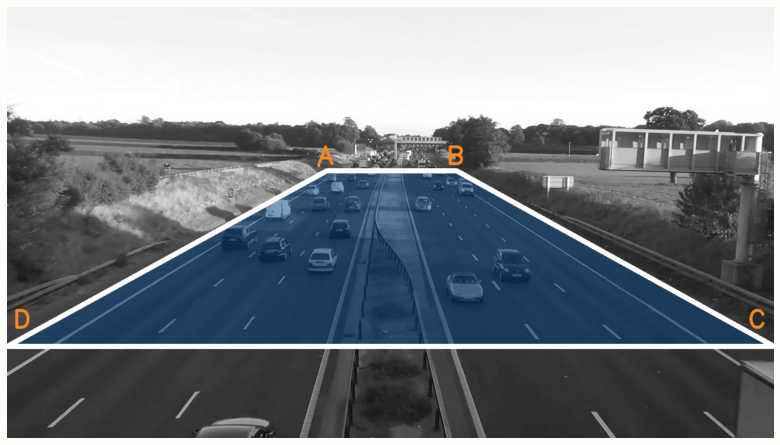

In [21]:
cap = cv.VideoCapture(SOURCE_VIDEO)
ret, img = cap.read()
cap.release()

img = cv.cvtColor(cv.cvtColor(img, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2BGR)

color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")
poly = np.array(((800, 410), (1125, 410), (1920, 850), (0, 850)))

img = sv.draw_filled_polygon(img, poly, color1, 0.5)
img = sv.draw_polygon(img, poly, sv.Color.WHITE, 12)
img = sv.draw_text(img, "A", sv.Point(800, 370), color2, 2, 6)
img = sv.draw_text(img, "B", sv.Point(1125, 370), color2, 2, 6)
img = sv.draw_text(img, "C", sv.Point(1880, 780), color2, 2, 6)
img = sv.draw_text(img, "D", sv.Point(40, 780), color2, 2, 6)

imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [22]:
class Cam2WorldMapper:
    """Maps points from image to world coordinates using perspective transform."""

    def __init__(self) -> None:
        self.M: NDArray | None = None

    def __call__(self, image_pts: ArrayLike) -> NDArray:
        return self.map(image_pts)

    def find_perspective_transform(self, image_pts: ArrayLike, world_pts: ArrayLike) -> NDArray:
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        world_pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        self.M = cv.getPerspectiveTransform(image_pts, world_pts)
        return self.M

    def map(self, image_pts: ArrayLike) -> NDArray:
        if self.M is None:
            raise ValueError("Perspective transform not estimated")
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(image_pts, self.M).reshape(-1, 2)

In [23]:
# A, B, C, D previously found in the image.
image_pts = [(800, 410), (1125, 410), (1920, 850), (0, 850)]
# M6 is roughly 32 meters wide and 140 meters long there.
world_pts = [(0, 0), (32, 0), (32, 140), (0, 140)]

mapper = Cam2WorldMapper()
mapper.find_perspective_transform(image_pts, world_pts)
print(mapper.M)

[[  -0.027557   -0.050103      42.587]
 [-2.9606e-17    -0.52608      215.69]
 [         -0  -0.0031216           1]]


In [24]:
MPS_TO_KPH = 3.6


class Speedometer:
    """Estimates speed of objects in the world coordinates."""

    def __init__(self, mapper: Cam2WorldMapper, fps: int, unit: float = MPS_TO_KPH) -> None:
        self._mapper = mapper
        self._fps = fps
        self._unit = unit
        self._speeds: defaultdict[int, list[int]] = defaultdict(list)

    @property
    def speeds(self) -> defaultdict[int, list[int]]:
        return self._speeds

    def update_with_trace(self, idx: int, image_trace: NDArray) -> None:
        if len(image_trace) > 1:
            world_trace = self._mapper(image_trace)
            # Median displacement in x and y directions.
            # This stabilises after around several frames.
            dx, dy = np.median(np.abs(np.diff(world_trace, axis=0)), axis=0)
            ds = np.linalg.norm((dx, dy))
            self._speeds[idx].append(int(ds * self._fps * self._unit))

    def get_current_speed(self, idx: int) -> int:
        return self._speeds[idx][-1] if self._speeds[idx] else 0

In [25]:
# Custom color palette for object tracking.
colors = ("#007fff", "#0072e6", "#0066cc", "#0059b3", "#004c99", "#004080", "#003366", "#00264d")
color_palette = sv.ColorPalette(list(map(sv.Color.from_hex, colors)))

# The supervision VideoInfo provides some metadata about the video.
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
FPS = video_info.fps

# Polygonal zone that masks out detected objects that are outside it.
poly = np.array([(0, 410), (1920, 410), (1920, 900), (0, 900)])
zone = sv.PolygonZone(poly, (sv.Position.TOP_CENTER, sv.Position.BOTTOM_CENTER))

bbox_annotator = sv.BoxAnnotator(
    color=color_palette,
    thickness=2,
    color_lookup=sv.ColorLookup.TRACK,
)
trace_annotator = sv.TraceAnnotator(
    color=color_palette,
    position=sv.Position.CENTER,
    thickness=2,
    trace_length=FPS,
    color_lookup=sv.ColorLookup.TRACK,
)
label_annotator = sv.RichLabelAnnotator(
    color=color_palette,
    border_radius=2,
    font_size=16,
    color_lookup=sv.ColorLookup.TRACK,
    text_padding=6,
)

In [ ]:
yolo = YOLO("yolo11m.pt", task="detect")
speedometer = Speedometer(mapper, FPS)

output_video = "vehicles_annotated.mp4"
width, height = video_info.resolution_wh  # Inferenced image size
# YOLO expects the image size to be a multiple of 32
width, height = round(width / 32) * 32, round(height / 32) * 32
classes = [2, 5, 7]  # Car, Bus, Truck
conf = 0.4  # Detetion confidence threshold

with sv.VideoSink(output_video, video_info) as sink:
    for frame in sv.get_video_frames_generator(SOURCE_VIDEO):
        result = yolo.track(
            frame,
            classes=classes,
            conf=conf,
            imgsz=(height, width),
            persist=True,
            verbose=False,
            tracker="bytetrack.yaml",
        )
        detection = sv.Detections.from_ultralytics(result[0])
        # Mask out detections outside the zone.
        detection = detection[zone.trigger(detections=detection)]

        trace_ids = detection.tracker_id  # type: ignore
        speeds: list[int] = list()
        labels: list[str] = list()

        for trace_id in trace_ids:  # type: ignore
            image_trace = trace_annotator.trace.get(trace_id)
            speedometer.update_with_trace(int(trace_id), image_trace)
            current_speed = speedometer.get_current_speed(int(trace_id))
            speeds.append(current_speed)
            labels.append(f"#{trace_id} {current_speed} km/h")

        frame = cv.cvtColor(cv.cvtColor(frame, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2RGB)
        frame = bbox_annotator.annotate(frame, detection)  # type: ignore
        frame = trace_annotator.annotate(frame, detection)  # type: ignore
        frame = label_annotator.annotate(frame, detection, labels=labels)  # type: ignore
        sink.write_frame(frame)

100%|██████████| 38.8M/38.8M [00:02<00:00, 19.5MB/s]
